In [1]:
!pip3 install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=3b2ef24df43bb3300b684dd6d0b6d9aadf9fabcab1f93e0aa6d541d502378dd8
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from imutils.paths import list_images
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19

plt.style.use('_mpl-gallery-nogrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Setup various directories
input_dir = '/kaggle/input'
output_dir = '/kaggle/working'
temp_dir = '/kaggle/temp'
logs_dir = os.path.join(output_dir, 'logs')

if not os.path.exists(logs_dir):
    os.mkdir(logs_dir)

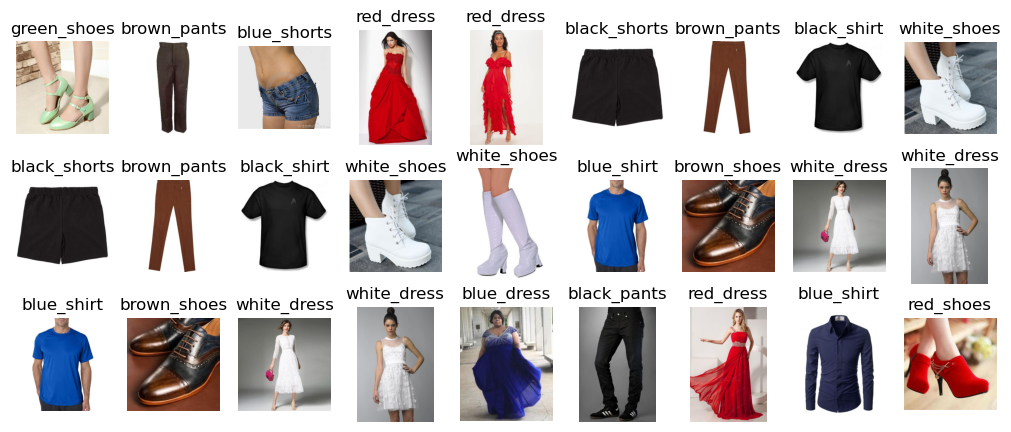

In [4]:
# Getting the paths of images
img_paths = list(list_images(input_dir))
img_paths.sort()

# Shuffles the image paths
random.seed(42)
random.shuffle(img_paths)

# # Putting images in data list
# for img_path in img_paths:
#     img = cv2.imread(img_path)

# Showing samples
fig, subplots = plt.subplots(3, 9, figsize=(10, 4))
for i in range(subplots.shape[0]):
    for j in range(subplots.shape[1]):
        subplots[i, j].imshow( cv2.cvtColor(cv2.imread(img_paths[(5 * i) + j]), cv2.COLOR_BGR2RGB) )
        subplots[i, j].set_axis_off()
        subplots[i, j].set_title(img_paths[(5 * i) + j].split(os.path.sep)[-2])

fig.show()

In [5]:
# Setting up data and labels lists
data = []
labels = []

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

count = 0
for img_path in img_paths:
    count += 1
    if (count % 1000) == 0:
        print("Completed", count, "images.")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    data.append(img)
    
    label = img_path.split(os.path.sep)[-2]
    labels.append(label)
print("Completed", count, "images.")

Completed 1000 images.
Completed 2000 images.
Completed 3000 images.
Completed 4000 images.
Completed 5000 images.
Completed 6000 images.
Completed 7000 images.
Completed 8000 images.
Completed 9000 images.
Completed 10000 images.
Completed 11000 images.
Completed 11385 images.


In [6]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

In [7]:
# One hot encoding for labels
lb = LabelBinarizer()
one_hot_labels = lb.fit_transform(labels)

In [8]:
# Saving data and labels as pickle objects
import pickle

with open('pickle_data_list', 'wb') as file:
    pickle.dump(data, file)

with open('pickle_labels_list', 'wb') as file:
    pickle.dump(labels, file)

with open('one_hot_labels', 'wb') as file:
    pickle.dump(one_hot_labels, file)

In [9]:
# Load data and labels from pickle files
import pickle

data = None
labels = None
one_hot_labels = None

with open('pickle_data_list', 'rb') as file:
    data = pickle.load(file)

with open('pickle_labels_list', 'rb') as file:
    labels = pickle.load(file)

with open('one_hot_labels', 'rb') as file:
    one_hot_labels = pickle.load(file)

In [10]:
if torch.cuda.is_available():
    dev = 'cuda:0'
    torch.cuda.set_device(dev)
else:
    dev = 'cpu'
torch.cuda.is_available()

True

In [11]:
# Split into training and test datasets
(trainX, testX, trainY, testY) = train_test_split(data, one_hot_labels, test_size=0.15, random_state=42)

In [12]:
# Show shapes
print("trainX:", trainX.shape)
print("testX:", testX.shape)
print("trainY:", trainY.shape)
print("testY:", testY.shape)

trainX: (9677, 64, 64, 3)
testX: (1708, 64, 64, 3)
trainY: (9677, 24)
testY: (1708, 24)


In [13]:
sigmoid = torch.nn.Softmax(dim=1)

def compute_acc(pred, target):
    predicted = torch.argmax(pred, dim=1).cpu()
    actual = torch.argmax(torch.Tensor(target).cpu(), dim=1)
    return predicted.eq(actual).sum().float() / predicted.numel()

def evaluate(test_inputs, test_labels):
    model.eval()
    test_inputs = torch.Tensor(np.einsum("ijkl->iljk", test_inputs)).to(dev)
    pred_labels = sigmoid(model(test_inputs))
    model.train()
    
    return compute_acc(pred_labels, test_labels)

In [14]:
aug = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [15]:
model = vgg19(num_classes=lb.classes_.size)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

model.to(dev)
model.train()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
no_of_epochs = 90
train_len = trainY.shape[0]
batch_size = 64

epoch_loss = []
granular_loss = []

epoch_acc = []
granular_acc = []

test_acc = []

model.train()

for epoch_num in range(no_of_epochs):
    count = 0
    print_count = 0
    batch_count = 0
    cur_epoch_loss = 0
    cur_epoch_acc = 0
    
    aug_iter = aug.flow(trainX, trainY, batch_size=batch_size)
    for train_x, train_y in aug_iter:
        train_x = torch.Tensor(np.einsum("ijkl->iljk", train_x)).to(dev)
        predY = model(train_x)
        loss = loss_fn(predY, torch.Tensor(train_y).to(dev))
        acc = compute_acc(predY, train_y)

        if  ((2000 * print_count) <= count) and (count < ((2000 * print_count) + batch_size)):
            print(f"Completed {count} images in Epoch {epoch_num+1}, loss: {loss.item()}, acc: {acc}")
            print_count += 1
        granular_loss.append(loss.item())
        granular_acc.append(acc)
        cur_epoch_loss += loss.item()
        cur_epoch_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count += batch_size
        batch_count += 1
        
        if (count + batch_size) > train_len:
            break
    epoch_loss.append(cur_epoch_loss/batch_count)
    epoch_acc.append(cur_epoch_acc/batch_count)
    
    indics = list(range(testX.shape[0]))
    random.shuffle(indics)
    test_acc.append(evaluate(testX[indics][0:64], testY[indics][0:64]))
    
    print(f"Epoch {epoch_num+1} ended at count {count} with loss {epoch_loss[-1]}, accuracy {epoch_acc[-1]}, test accuracy {test_acc[-1]}.")
    print()
    
    if not ((epoch_num + 1) % 10):
        torch.save(model.state_dict(), os.path.join(output_dir, f"torch_vgg19_apparell_{epoch_num + 1:03}.pt"))
    
torch.save(model.state_dict(), os.path.join(output_dir, f"torch_vgg19_apparell_{epoch_num + 1:03}.pt"))

Completed 0 images in Epoch 1, loss: 3.17995285987854, acc: 0.015625
Completed 2048 images in Epoch 1, loss: 2.9752285480499268, acc: 0.078125
Completed 4032 images in Epoch 1, loss: 2.8657901287078857, acc: 0.046875
Completed 6016 images in Epoch 1, loss: 2.8091158866882324, acc: 0.171875
Completed 8000 images in Epoch 1, loss: 2.580564022064209, acc: 0.171875
Epoch 1 ended at count 9664 with loss 2.7776222781629754, accuracy 0.12179221957921982, test accuracy 0.21875.

Completed 0 images in Epoch 2, loss: 2.311781406402588, acc: 0.265625
Completed 2048 images in Epoch 2, loss: 2.098268508911133, acc: 0.1875
Completed 4032 images in Epoch 2, loss: 2.306209087371826, acc: 0.234375
Completed 6016 images in Epoch 2, loss: 2.096437931060791, acc: 0.265625
Completed 8000 images in Epoch 2, loss: 1.8893630504608154, acc: 0.34375
Epoch 2 ended at count 9664 with loss 2.035442225980443, accuracy 0.3085678815841675, test accuracy 0.46875.

Completed 0 images in Epoch 3, loss: 1.841706275939941

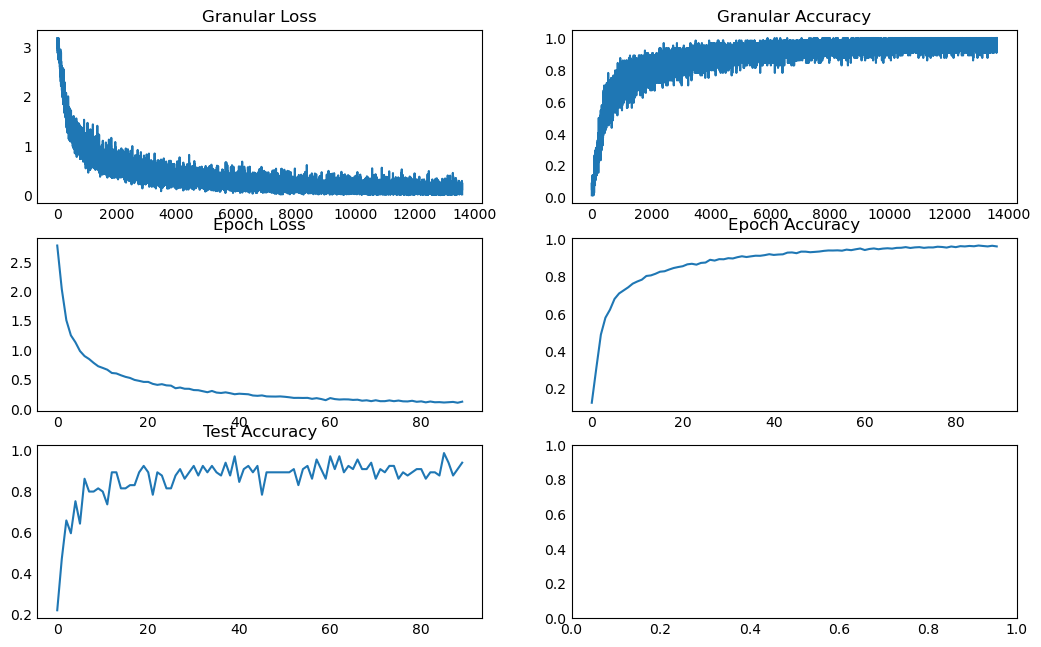

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

axes[0, 0].set_title("Granular Loss")
axes[0, 0].plot(granular_loss)

axes[0, 1].set_title("Granular Accuracy")
axes[0, 1].plot(granular_acc)

axes[1, 0].set_title("Epoch Loss")
axes[1, 0].plot(epoch_loss)

axes[1, 1].set_title("Epoch Accuracy")
axes[1, 1].plot(epoch_acc)

axes[2, 0].set_title("Test Accuracy")
axes[2, 0].plot(test_acc)

fig.show()

In [18]:
# Load the model
model = vgg19(num_classes=lb.classes_.size)
model.to(dev)

checkpoint = torch.load(os.path.join(output_dir, "torch_vgg19_apparell_090.pt"))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        assert inputs.shape[0] == labels.shape[0]
        self.inputs = inputs
        self.labels = labels
        self.length = inputs.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        image = self.inputs[idx]
        label = self.labels[idx]
        return image, label

Length of test dataset: 1708


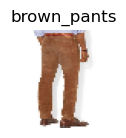

In [20]:
test_dataset = CustomDataset(testX, testY)
print(f"Length of test dataset: {len(test_dataset)}")

fig, axes = plt.subplots(1, 1, figsize=(1, 1))
axes.set_title(lb.inverse_transform( np.expand_dims(test_dataset[4][1], axis=0) )[0])
axes.set_axis_off()
axes.imshow(test_dataset[4][0])

fig.show()

In [21]:
test_len = testY.shape[0]
batch_size = 64

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
loss_fn = torch.nn.CrossEntropyLoss()

image_count = 0
batch_count = 0

test_acc_list = []
test_loss_list = []

model.eval()

for images, labels in test_dataloader:
    images = images.numpy()
    images = torch.Tensor(np.einsum("ijkl->iljk", images)).to(dev)
    labels = labels.to(dtype=torch.float, device=dev)
    
    predY = model(images)
    loss = loss_fn(predY, labels)
    predY = sigmoid(predY)
    acc = compute_acc(predY, labels)
    
    test_acc_list.append(acc)
    test_loss_list.append(loss.item())
    
    image_count += images.shape[0]
    batch_count += 1
    
    print(f"Tested {image_count} images till batch {batch_count}.")

test_acc = sum(test_acc_list) / len(test_acc_list)
test_loss = sum(test_loss_list) / len(test_loss_list)

print(f"Test Loss = {test_loss} | Test Accuracy = {test_acc}")

Tested 64 images till batch 1.
Tested 128 images till batch 2.
Tested 192 images till batch 3.
Tested 256 images till batch 4.
Tested 320 images till batch 5.
Tested 384 images till batch 6.
Tested 448 images till batch 7.
Tested 512 images till batch 8.
Tested 576 images till batch 9.
Tested 640 images till batch 10.
Tested 704 images till batch 11.
Tested 768 images till batch 12.
Tested 832 images till batch 13.
Tested 896 images till batch 14.
Tested 960 images till batch 15.
Tested 1024 images till batch 16.
Tested 1088 images till batch 17.
Tested 1152 images till batch 18.
Tested 1216 images till batch 19.
Tested 1280 images till batch 20.
Tested 1344 images till batch 21.
Tested 1408 images till batch 22.
Tested 1472 images till batch 23.
Tested 1536 images till batch 24.
Tested 1600 images till batch 25.
Tested 1664 images till batch 26.
Tested 1708 images till batch 27.
Test Loss = 0.33411867581997756 | Test Accuracy = 0.9182975888252258
